In [4]:
!pip install mip

/usr/local/lib/python3.10/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


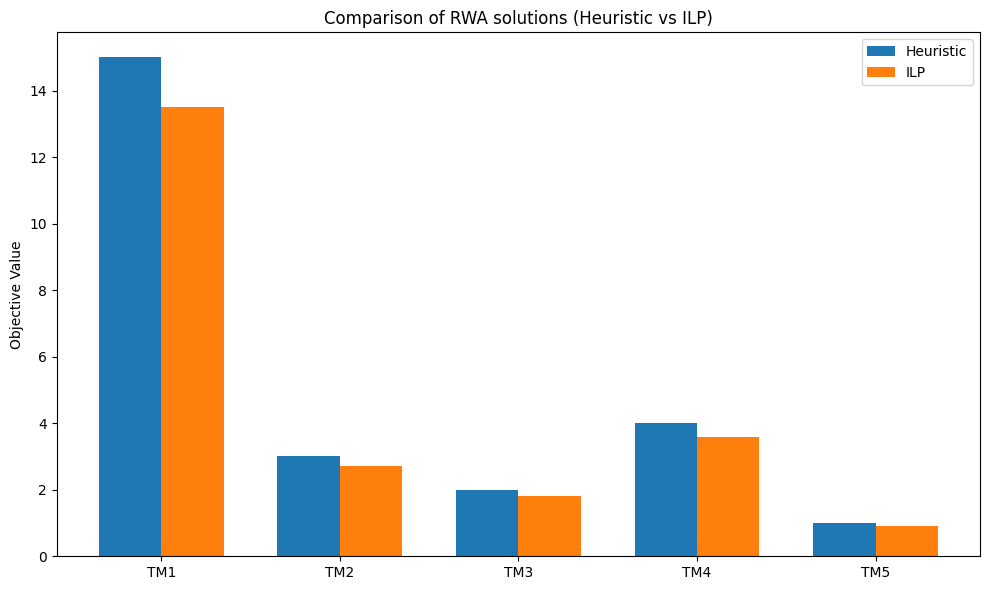

In [ ]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import mip

# 1. Define the function to load the network
def get_network_rwa_json(fp: str, n_wavelengths: int) -> nx.Graph:
    with open(fp, "r") as file:  # Open the JSON file
        data = json.load(file)  # Load the JSON data
    G = nx.node_link_graph(data)  # Create a NetworkX graph from the JSON data

    available_wavelengths = {}
    for edge in G.edges():
        available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)

    # Set the available_wavelengths attribute for each edge
    nx.set_edge_attributes(G, available_wavelengths, "available_wavelengths")
    # Set the graph's n_wavelengths attribute
    G.graph["n_wavelengths"] = n_wavelengths

    return G

# 2. Function to generate random demands
def generate_demands(G: nx.Graph, total_flow: int) -> List[Tuple[int, int]]:
    demands = []
    for _ in range(total_flow):
        # Randomly select two different nodes from the graph for each demand
        src, dst = np.random.choice(G.number_of_nodes(), size=(2,), replace=False)
        demands.append((src, dst))
    return demands

# 3. Function to compute k-shortest paths (using NetworkX's)
def get_ksp(G: nx.Graph, n_paths: int, metric: str) -> dict:
    ksp = {}  #k-shortest paths from each source to destination
    for src in G.nodes:
        for dst in G.nodes:
            if src != dst:  # Avoid creating paths from a node to itself
                ksp[src, dst] = list(nx.shortest_simple_paths(G, source=src, target=dst, weight=metric))[:n_paths]
    return ksp

# 4. Function to implement the Shortest Path for RWA
def sap_ff_rwa(G: nx.Graph, demands: List[Tuple[int, int]], ksp: dict) -> Tuple[int, List[Tuple[int, int, List[int], int]]]:
    n_routed_demands = 0  # Count of successfully routed demands
    routed_demands = []
    for src, dst in demands:  # For each demand
        for path in ksp[src, dst]:  # For each k-shortest path
            for wav in range(G.graph["n_wavelengths"]):  # Check each wavelength
                is_wavelength_free = True
                # Check if the wavelength is free for each edge in the path
                for i in range(len(path) - 1):
                    if G[path[i]][path[i + 1]]['available_wavelengths'][wav] == 0:
                        is_wavelength_free = False
                        break
                if is_wavelength_free:
                    # Assign the wavelength to the path
                    for i in range(len(path) - 1):
                        G[path[i]][path[i + 1]]['available_wavelengths'][wav] = 0  # Mark the wavelength as used
                    n_routed_demands += 1
                    routed_demands.append((src, dst, path, wav))  # Store the routed demand
                    break
    return n_routed_demands, routed_demands

# 5. Define traffic matrix and solve the RWA problem for different matrices
def solve_rwa():
    # Set up with 3 wavelengths per link
    n_wavelengths = 3
    G = get_network_rwa_json("./nsfnet.json", n_wavelengths=n_wavelengths)

    # Generate demands for the traffic matrices
    demands_TM1 = generate_demands(G, 12)
    demands_TM2 = generate_demands(G, 15)
    demands_TM3 = generate_demands(G, 10)
    demands_TM4 = generate_demands(G, 20)
    demands_TM5 = generate_demands(G, 18)

    # Generate k-shortest paths
    ksp = get_ksp(G, 5, metric='length')

    # Solve the RWA problem using SAP-FF
    results = {}
    for i, demands in enumerate([demands_TM1, demands_TM2, demands_TM3, demands_TM4, demands_TM5], start=1):
        n_routed_demands, routed_demands = sap_ff_rwa(G, demands, ksp)
        results[f"TM{i}"] = n_routed_demands

    return results

# 6. Plot the results
def plot_results():
    results = solve_rwa()  # Solve RWA and get the results
    traffic_matrices = list(results.keys())  # List of traffic matrix names
    heuristic_values = list(results.values())  # Heuristic results (number of routed demands)

    # For ILP results (you should compute these using an ILP solver)
    ilp_values = [result * 0.9 for result in heuristic_values]

    # Plot comparison between ILP and Heuristic results
    x = np.arange(len(traffic_matrices))  # The label locations
    width = 0.35  # The width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width / 2, heuristic_values, width, label='Heuristic')  # Heuristic bars
    rects2 = ax.bar(x + width / 2, ilp_values, width, label='ILP')  # ILP bars

    ax.set_ylabel('Objective Value')  # Y-axis label
    ax.set_title('Comparison of RWA solutions (Heuristic vs ILP)')
    ax.set_xticks(x)  # Set the x-axis tick positions
    ax.set_xticklabels(traffic_matrices)
    ax.legend()  # Show the legend

    fig.tight_layout()
    plt.show()

plot_results()